In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import numpy as np
from sklearn.utils import resample

In [31]:
# Some defitions
IPAQ = 'IPAQ activity group | Instance 0'
PRS = 'Standard PRS for breast cancer (BC)'
PRS_QUARTILE = 'prs_quartile'
NUMBER_CANCERS = 'number_cancer'
HAS_BC = 'Breast'
ACCELEROMETER = 'Moderate-Vigorous - Overall average | Instance 0'
AC_QUARTILE = 'ac_quartile'

In [32]:
demographics = pd.read_csv('cleaned_participant_table.csv')
diagnosis = pd.read_csv('cleaned_diagnosis_data.csv')

print(len(diagnosis))
print(len(demographics))

df = demographics.merge(diagnosis, right_on='eid', left_on='Participant ID', how='left').reset_index()
df.info(show_counts=True)

20125
50854
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50854 entries, 0 to 50853
Data columns (total 22 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   index                                             50854 non-null  int64  
 1   Unnamed: 0_x                                      50854 non-null  int64  
 2   Participant ID                                    50854 non-null  int64  
 3   age                                               20854 non-null  float64
 4   Sex                                               50854 non-null  object 
 5   Townsend deprivation index at recruitment         20835 non-null  float64
 6   BMI                                               20753 non-null  float64
 7   Smoking                                           20830 non-null  object 
 8   IPAQ activity group | Instance 0                  45193 non-null  object 
 9   Moder

In [33]:
# Substitute null values for breast cancer and number_cancers (aka for controls)
df[HAS_BC] = df[HAS_BC].fillna(False)
df[NUMBER_CANCERS] = df[NUMBER_CANCERS].fillna(0)

/var/folders/11/krx912jd2nqgvltq6nl2ghc00000gn/T/ipykernel_37833/1106995060.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[HAS_BC] = df[HAS_BC].fillna(False)


In [114]:
## PICK THE SPORT MEASUREMENT ##

SPORT = IPAQ
#SPORT = ACCELEROMETER

# Separate cancer and non-cancer cases
clean_df = df[
    (df[SPORT].notnull()) & 
    (df[PRS].notnull()) & 
    (df[NUMBER_CANCERS] <= 1)
]
cancer_group = clean_df[clean_df[NUMBER_CANCERS] == 1]
control_group = clean_df[clean_df[NUMBER_CANCERS] == 0]

# Undersample the control group to match the size of the cancer group
control_group_balanced = resample(control_group, 
                                  replace=False,  # No replacement, as we want to reduce size
                                  n_samples=len(cancer_group),  # Match size of cancer group
                                  random_state=42)  # For reproducibility

# Combine balanced data
sport_df = pd.concat([cancer_group, control_group_balanced])

# Confirm the balance
print(sport_df[NUMBER_CANCERS].value_counts())

number_cancer
1.0    13556
0.0    13556
Name: count, dtype: int64


In [115]:
## Do people with a higher PRS develop cancer more frequently? ##

# Add PRS Quartile
sport_df[PRS_QUARTILE]= pd.qcut(sport_df[PRS], q=3, labels=["Q1", "Q2", "Q3"])

# Add accelerometer quartiles
sport_df[ACCELEROMETER], bins= pd.qcut(sport_df[ACCELEROMETER], q=3, labels=["low", "moderate", "high"], retbins=True)
print(bins)

# Fix IPAQ order
sport_df[IPAQ] = pd.Categorical(sport_df[IPAQ], 
                                  categories=["low", "moderate", "high"], 
                                  ordered=True)

# Group by PRS quartile and IPAQ score
group_by = [PRS_QUARTILE, SPORT]
grouped = sport_df.groupby(group_by).agg(
    total_people=(NUMBER_CANCERS, 'count'),
    cancer_cases=(NUMBER_CANCERS, 'sum')
).reset_index()

# Calculate the cancer rate (% of people who developed cancer)
grouped['cancer_rate'] = (grouped['cancer_cases'] / grouped['total_people']) * 100

# Normalize within each PRS quartile (to emphasize variation) - for each cancer_rate, what % is that of the total quartile rate
grouped['normalized_cancer_rate'] = grouped.groupby(PRS_QUARTILE)['cancer_rate'].transform(
    lambda x: x / x.sum()
    #lambda x: (x-x.min()) / x.min()
)

# Display the results sorted by quartile and IPAQ score
grouped = grouped.sort_values(group_by)
display(grouped)

[0.      0.0123  0.02877 1.     ]


/var/folders/11/krx912jd2nqgvltq6nl2ghc00000gn/T/ipykernel_37833/1999393105.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = sport_df.groupby(group_by).agg(
/var/folders/11/krx912jd2nqgvltq6nl2ghc00000gn/T/ipykernel_37833/1999393105.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped['normalized_cancer_rate'] = grouped.groupby(PRS_QUARTILE)['cancer_rate'].transform(


,prs_quartile,IPAQ activity group | Instance 0,total_people,cancer_cases,cancer_rate,normalized_cancer_rate
0,Q1,low,1548,606.0,39.147287,0.363478
1,Q1,moderate,3939,1360.0,34.526530,0.320575
2,Q1,high,3550,1208.0,34.028169,0.315947
3,Q2,low,1612,879.0,54.528536,0.360981
4,Q2,moderate,3921,1915.0,48.839582,0.323320
5,Q2,high,3504,1671.0,47.688356,0.315699
6,Q3,low,1639,1125.0,68.639414,0.346219
7,Q3,moderate,4016,2583.0,64.317729,0.324420
8,Q3,high,3383,2209.0,65.297074,0.329360


Chi-Square Statistic: 45.615386175812304
P-Value: 1.2437833734238978e-10
Significant association between IPAQ score and cancer development.


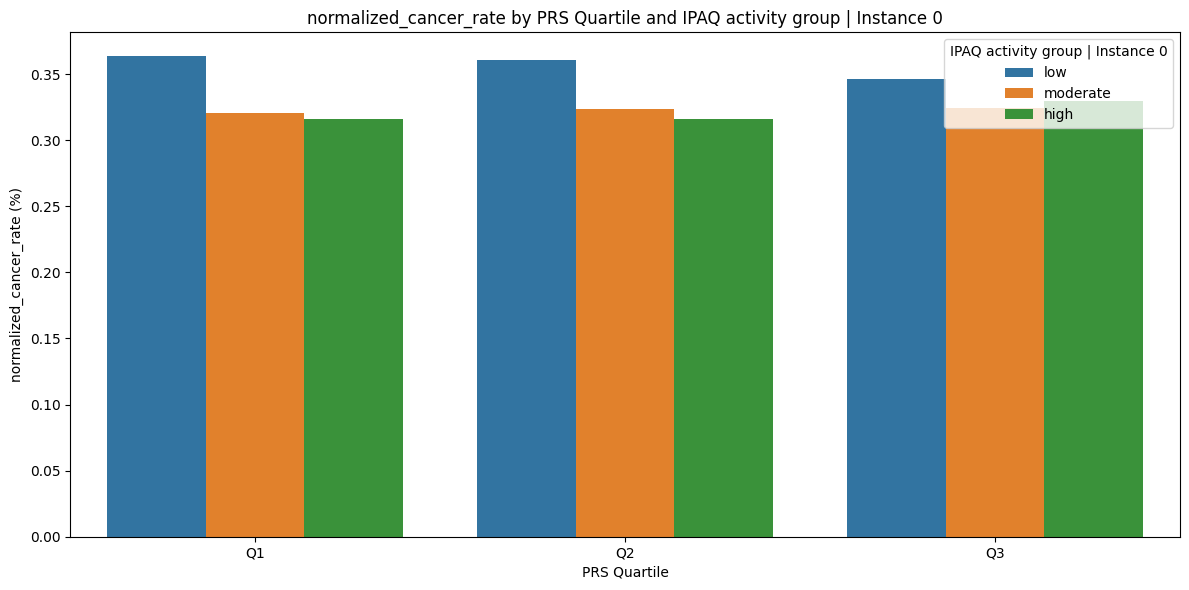

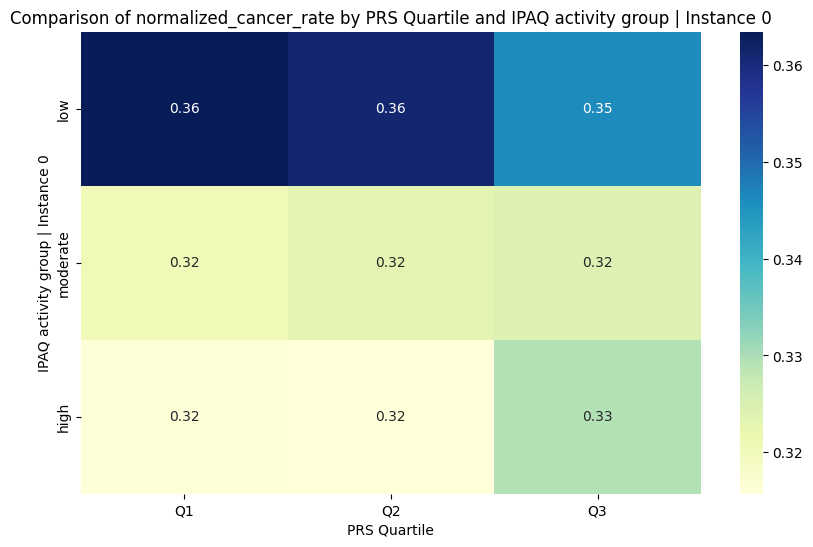

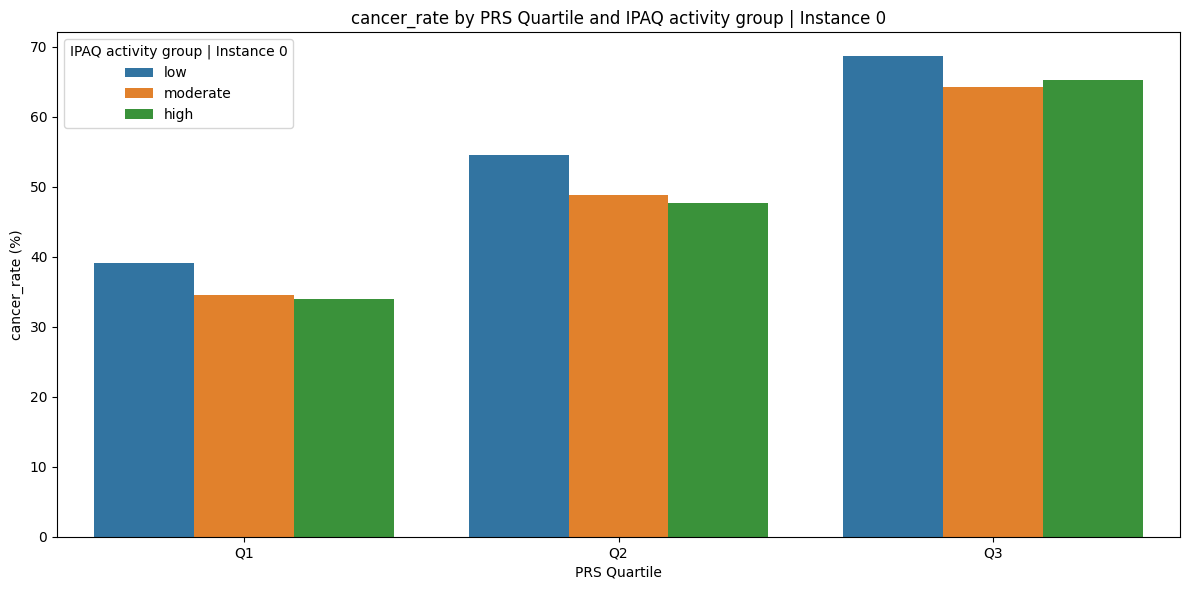

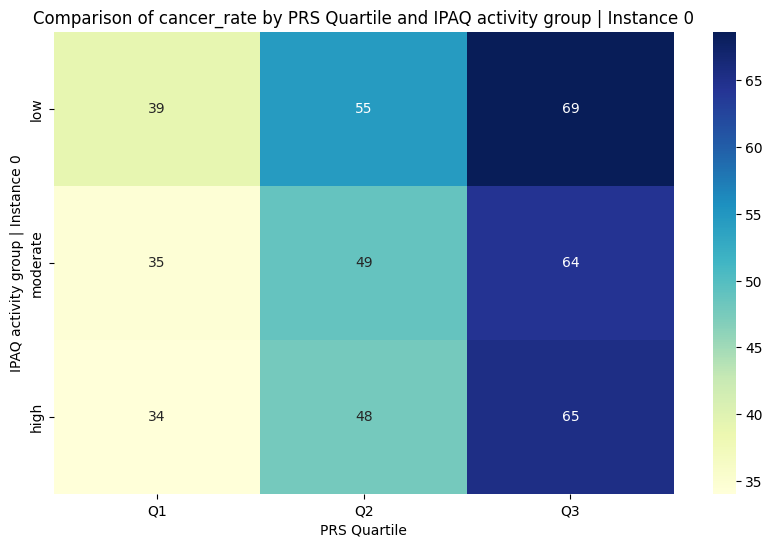

In [116]:
# Create a contingency table for statistical testing
contingency_table = pd.crosstab(sport_df[SPORT], sport_df[NUMBER_CANCERS])

# Perform the Chi-Square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Significant association between IPAQ score and cancer development.")
else:
    print("No significant association found.")

# Plotting cancer rate by PRS quartile and SPORT
values = ['normalized_cancer_rate', 'cancer_rate']

for value in values: 
    # Bar Chart 
    plt.figure(figsize=(12, 6))
    sns.barplot(data=grouped, x=PRS_QUARTILE, y=value, hue=SPORT)
    plt.title('{0} by PRS Quartile and {1}'.format(value, SPORT))
    plt.ylabel('{0} (%)'.format(value))
    plt.xlabel('PRS Quartile')
    plt.legend(title=SPORT)
    plt.tight_layout()
    plt.show()

    # Heatmap
    pivot = grouped.pivot(index=SPORT, columns=PRS_QUARTILE, values=value)
    
    # Plot heatmap to compare cancer rates
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, cmap="YlGnBu")
    plt.title('Comparison of {0} by PRS Quartile and {1}'.format(value, SPORT))
    plt.ylabel(SPORT)
    plt.xlabel('PRS Quartile')
    plt.show()

In [53]:
def chi_square_test(df):
    results = []
    for prs in ['Q1' ,'Q2', 'Q3', 'Q4']:
        subset = df[df[PRS_QUARTILE] == prs]
        
        # Create contingency table: IPAQ vs Cancer Cases
        contingency_table = pd.crosstab(subset[SPORT], subset[NUMBER_CANCERS])
        
        # Perform Chi-Square test
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        results.append({'PRS Quartile': prs, 'Chi-Square Stat': chi2, 'p-value': p_value})
        
        print(f"\nPRS Quartile {prs}")
        print(contingency_table)
        print(f"Chi-Square Stat: {chi2:.4f}, p-value: {p_value:.4f}")

        # Interpretation
        if p_value < 0.05:
            print("→ Significant variation by IPAQ score!")
        else:
            print("→ No significant variation by IPAQ score.")
    
    # Convert results to DataFrame for easy viewing
    return pd.DataFrame(results)

# Run the test
chi_square_results = chi_square_test(sport_df)


PRS Quartile Q1
number_cancer                                     0.0  1.0
Moderate-Vigorous - Overall average | Instance 0          
Q1                                                277  172
Q2                                                282  164
Q3                                                332  151
Q4                                                333  140
Chi-Square Stat: 10.9418, p-value: 0.0120
→ Significant variation by IPAQ score!

PRS Quartile Q2
number_cancer                                     0.0  1.0
Moderate-Vigorous - Overall average | Instance 0          
Q1                                                221  235
Q2                                                253  204
Q3                                                264  203
Q4                                                286  184
Chi-Square Stat: 14.7655, p-value: 0.0020
→ Significant variation by IPAQ score!

PRS Quartile Q3
number_cancer                                     0.0  1.0
Moderate-Vigorous - 

In [81]:
sport_df[PRS_QUARTILE] = pd.Categorical(sport_df[PRS_QUARTILE])

# Encode categorical variables as numeric (required for statsmodels)
sport_df['sports_score_code'] = sport_df[SPORT].cat.codes
sport_df['prs_quartile_code'] = sport_df[PRS_QUARTILE].cat.codes

def logistic_regression(df):
    results = []
    for prs in ['Q1' ,'Q2', 'Q3', 'Q4']:
        subset = df[df[PRS_QUARTILE] == prs]
        
        # Define outcome (Y) and predictor (X)
        X = subset[['sports_score_code']]  # Predictor (IPAQ quartile)
        y = subset[NUMBER_CANCERS]  # Outcome
        
        # Add a constant for the intercept
        X = sm.add_constant(X)
        
        # Fit logistic regression model
        model = sm.Logit(y, X).fit(disp=0)  # Suppress output during fitting
        summary = model.summary2()
        display(summary)
        
        # Calculate odds ratio and confidence intervals
        odds_ratios = pd.DataFrame(np.exp(model.params), columns=['Odds Ratio'])
        conf = np.exp(model.conf_int())
        conf.columns = ['2.5%', '97.5%']
        odds_ratios = pd.concat([odds_ratios, conf], axis=1)

        # Store results
        results.append({
            'PRS Quartile': prs,
            'Odds Ratio for IPAQ': odds_ratios.loc['sports_score_code', 'Odds Ratio'],
            '95% CI Lower': odds_ratios.loc['sports_score_code', '2.5%'],
            '95% CI Upper': odds_ratios.loc['sports_score_code', '97.5%'],
            'p-value': model.pvalues['sports_score_code']
        })
        
        print(f"\nPRS Quartile {prs} Logistic Regression Results:")
        print(odds_ratios)
        print(f"p-value: {model.pvalues['sports_score_code']:.4f}")

    return pd.DataFrame(results)

# Run logistic regression and store results
logistic_results = logistic_regression(sport_df)
logistic_results

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:               Logit            Method:           MLE      
Dependent Variable:  number_cancer    Pseudo R-squared: 0.004    
Date:                2025-01-07 20:59 AIC:              2363.6754
No. Observations:    1851             BIC:              2374.7224
Df Model:            1                Log-Likelihood:   -1179.8  
Df Residuals:        1849             LL-Null:          -1185.0  
Converged:           1.0000           LLR p-value:      0.0013156
No. Iterations:      5.0000           Scale:            1.0000   
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const             -0.4563   0.0816 -5.5900 0.0000 -0.6163 -0.2963
sports_score_code -0.1417   0.0442 -3.2050 0.0014 -0.2283 -0.0550
=================================================================

"""


PRS Quartile Q1 Logistic Regression Results:
                   Odds Ratio      2.5%     97.5%
const                0.633627  0.539948  0.743559
sports_score_code    0.867920  0.795900  0.946457
p-value: 0.0014


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Method:           MLE       
Dependent Variable: number_cancer    Pseudo R-squared: 0.005     
Date:               2025-01-07 20:59 AIC:              2533.6571 
No. Observations:   1850             BIC:              2544.7029 
Df Model:           1                Log-Likelihood:   -1264.8   
Df Residuals:       1848             LL-Null:          -1271.7   
Converged:          1.0000           LLR p-value:      0.00020821
No. Iterations:     4.0000           Scale:            1.0000    
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const              0.0190   0.0784  0.2426 0.8083 -0.1347  0.1727
sports_score_code -0.1556   0.0421 -3.6975 0.0002 -0.2380 -0.0731
=================================================================

"""


PRS Quartile Q2 Logistic Regression Results:
                   Odds Ratio      2.5%    97.5%
const                1.019210  0.873990  1.18856
sports_score_code    0.855942  0.788197  0.92951
p-value: 0.0002


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Method:           MLE       
Dependent Variable: number_cancer    Pseudo R-squared: 0.004     
Date:               2025-01-07 20:59 AIC:              2542.0188 
No. Observations:   1850             BIC:              2553.0647 
Df Model:           1                Log-Likelihood:   -1269.0   
Df Residuals:       1848             LL-Null:          -1274.7   
Converged:          1.0000           LLR p-value:      0.00075509
No. Iterations:     4.0000           Scale:            1.0000    
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const              0.3937   0.0787  5.0001 0.0000  0.2394  0.5480
sports_score_code -0.1418   0.0422 -3.3603 0.0008 -0.2246 -0.0591
=================================================================

"""


PRS Quartile Q3 Logistic Regression Results:
                   Odds Ratio      2.5%     97.5%
const                1.482473  1.270465  1.729859
sports_score_code    0.867755  0.798851  0.942601
p-value: 0.0008


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:               Logit            Method:           MLE      
Dependent Variable:  number_cancer    Pseudo R-squared: 0.002    
Date:                2025-01-07 20:59 AIC:              2349.3349
No. Observations:    1851             BIC:              2360.3819
Df Model:            1                Log-Likelihood:   -1172.7  
Df Residuals:        1849             LL-Null:          -1174.7  
Converged:           1.0000           LLR p-value:      0.044218 
No. Iterations:      5.0000           Scale:            1.0000   
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const              0.8362   0.0824 10.1458 0.0000  0.6747  0.9977
sports_score_code -0.0880   0.0438 -2.0103 0.0444 -0.1739 -0.0022
=================================================================

"""


PRS Quartile Q4 Logistic Regression Results:
                   Odds Ratio      2.5%     97.5%
const                2.307551  1.963350  2.712096
sports_score_code    0.915722  0.840397  0.997798
p-value: 0.0444


,PRS Quartile,Odds Ratio for IPAQ,95% CI Lower,95% CI Upper,p-value
0,Q1,0.867920,0.795900,0.946457,0.001350
1,Q2,0.855942,0.788197,0.929510,0.000218
2,Q3,0.867755,0.798851,0.942601,0.000779
3,Q4,0.915722,0.840397,0.997798,0.044400
